<h1><b>Students' Dropout and Academic Success Dataset </b></h1>

---

# Install required packages

In [3]:
%pip install matplotlib seaborn scikit-learn ucimlrepo graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import graphviz

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import display, Image

# **1. Fetch the dataset**

In [4]:
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 

{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

## **1.1 Data Preprocessing**

**Check if some features have missing values**

In [5]:
# Count the missing values in each column
print(X.isnull().sum())

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

There aren't missing values, so we don't need use one-hot encoding

Show target variable distribution

In [6]:
print(y.value_counts())

Target  
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


# **2. Spit the dataset into train and test sets**

## **2.1 Split the dataset**

In [7]:
# Define train/test proportions
train_sizes = [0.4, 0.6, 0.8, 0.9]

# Create all necessary subdirectories
base_dirs = ["feature_train", "feature_test", "label_train", "label_test"]
ratios = ["40_60", "60_40", "80_20", "90_10"]

for base_dir in base_dirs:
    for ratio in ratios:
        os.makedirs(os.path.join(base_dir, ratio), exist_ok=True)

for i, train_size in enumerate(train_sizes):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=train_size,
        stratify=y,
        shuffle=True,
        random_state=21
    )

    ratio_str = ratios[i]

    X_train_path = f"feature_train/{ratio_str}/X_train.csv"
    X_test_path = f"feature_test/{ratio_str}/X_test.csv"
    y_train_path = f"label_train/{ratio_str}/y_train.csv"
    y_test_path = f"label_test/{ratio_str}/y_test.csv"

    # Save to files
    X_train.to_csv(X_train_path, index=False)
    X_test.to_csv(X_test_path, index=False)
    y_train.to_csv(y_train_path, index=False)
    y_test.to_csv(y_test_path, index=False)


## **2.2 Class distribution**

In [8]:
def add_count_labels(ax, fontsize=8):
    for patch in ax.patches:
        height = patch.get_height()
        ax.annotate(f'{int(height)}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=fontsize)


def show_class_distribution(target_data, title):
    """Plot class distribution for a original dataset."""
    plt.figure(figsize=(10, 6))

    values = target_data.iloc[:, 0]

    order = ['Graduate', 'Dropout', 'Enrolled']
    ax = sns.countplot(x=values, order=order)
    plt.title(title)
    plt.xlabel('Enrollment Outcome')
    plt.ylabel('Count')

    add_count_labels(ax)
    plt.show()


def plot_single_dataset(ax, file_path, title, is_train=True):
    """Plot distribution for a single dataset."""
    df = pd.read_csv(file_path)
    values = df.iloc[:, 0]

    order = ['Graduate', 'Dropout', 'Enrolled']
    ax = sns.countplot(x=values, ax=ax, order=order)
    ax.set_title(title)
    ax.set_xlabel('Enrollment Outcome')
    ax.set_ylabel('Count')

    add_count_labels(ax, fontsize=8)


def compare_single_ratio(ratio):
    """Plot comparasion of class distribution."""
    _, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Train distribution
    train_path = os.path.join("label_train", ratio, "y_train.csv")
    plot_single_dataset(axes[0], train_path, f'Train {ratio.replace("_", "/")}')

    # Test distribution
    test_path = os.path.join("label_test", ratio, "y_test.csv")
    plot_single_dataset(axes[1], test_path, f'Test {ratio.replace("_", "/")}')

    plt.tight_layout()
    plt.suptitle(f'Train vs Test Comparison - Ratio {ratio.replace("_", ":")}')
    plt.show()

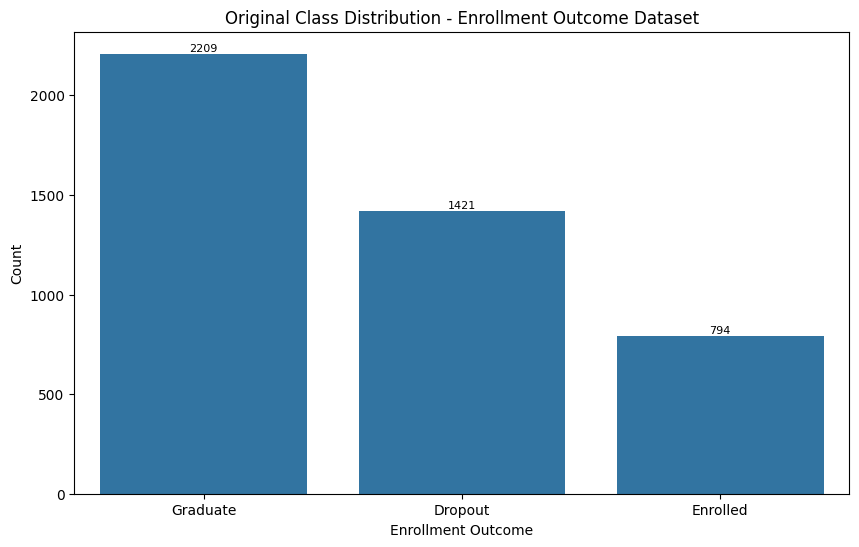

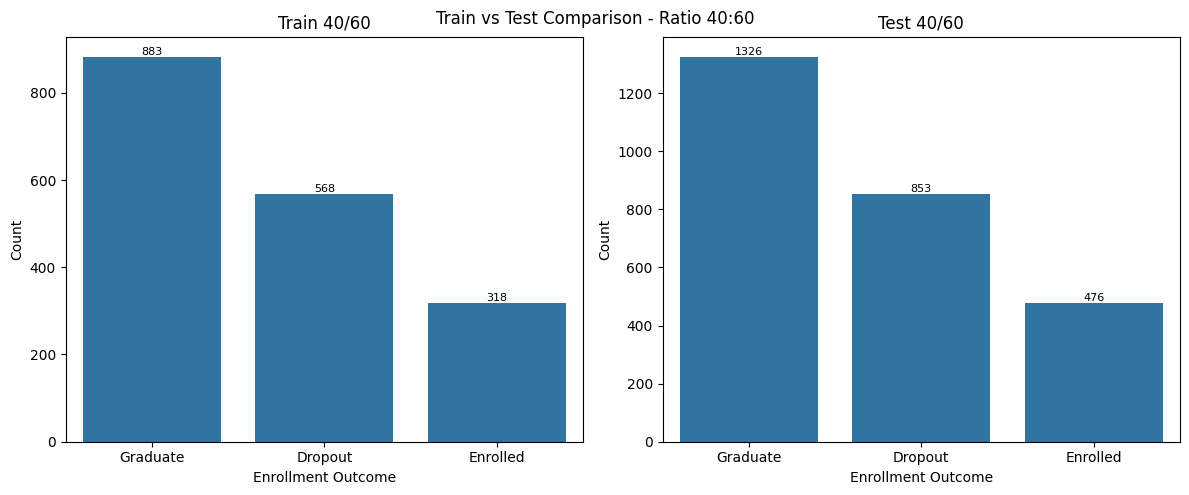

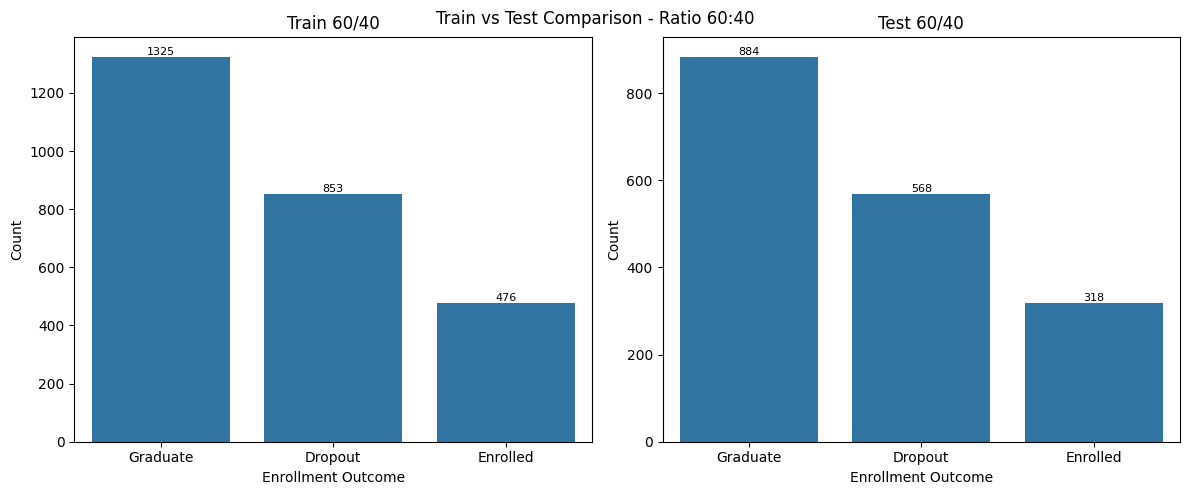

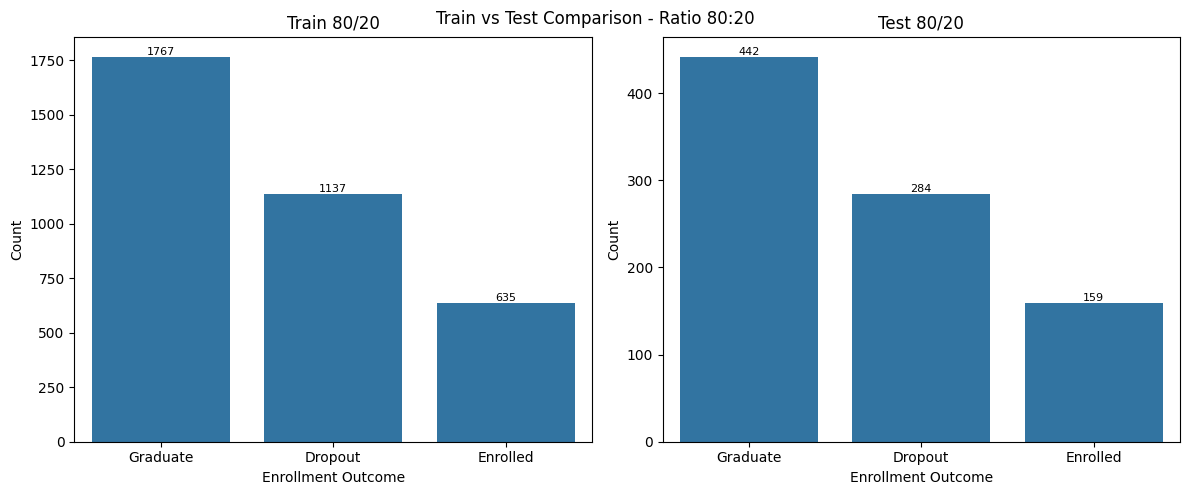

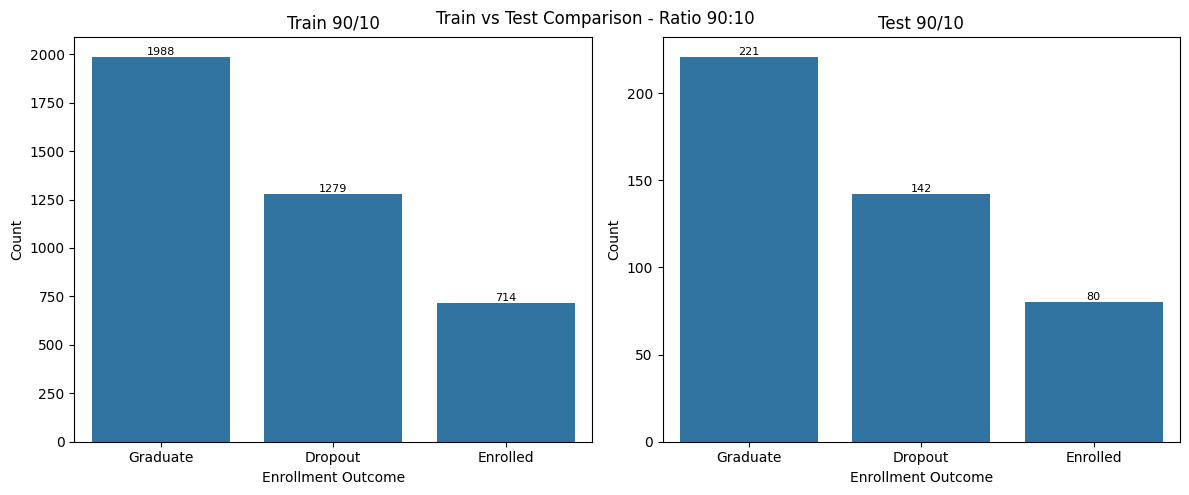

In [9]:
show_class_distribution(y, 'Original Class Distribution - Enrollment Outcome Dataset')

for ratio in ratios:
    compare_single_ratio(ratio)

# **3. Descision Tree Classifier**

## **3.1 Construct a Decision Tree Classifier**

In [10]:
def fit_and_visualize_decision_tree(X_train, y_train, ratio, max_depth=None, is_show=True, base_dir="images"):

    clf = DecisionTreeClassifier(
        criterion='entropy', max_depth=max_depth, random_state=42)

    # Train classifier
    clf.fit(X_train, y_train)

    # Visualize via Graphviz
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=X_train.columns,
        class_names=['Graduate', 'Dropout', 'Enrolled'],
        filled=True, rounded=True, special_characters=True
    )

    # Create graph object and save image
    graph = graphviz.Source(dot_data)

    # Generate PNG content and save to file
    png_content = graph.pipe(format='png')

    # Save the PNG image
    filename = f"{base_dir}/decision_tree_{ratio}-{max_depth}.png"
    with open(filename, 'wb') as f:
        f.write(png_content)

    if is_show:
        # Display the image
        display(Image(png_content))

    return clf

## **3.2. Evaluating the decision tree classifiers (No limit for max depth)**

In [11]:
def fit_and_evaluate_decision_tree(clf, X_test, y_test, ratio, max_depth=None):
    """Fit the classifier, make predictions, and evaluate performance."""
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    

    # Tạo classification report và confusion matrix
    report = classification_report(y_test, y_pred, digits=3)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # In kết quả
    print(f"Decision Tree Classifier Report (Max_depth: {max_depth})")
    print("Classification Report:\n", report)

    # Trực quan hóa confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf.classes_,
                yticklabels=clf.classes_)
    plt.title(
        f'Confusion Matrix (Train={round((1-ratio)*100, 0)}%, Test={round((ratio)*100, 0)}%, Depth={max_depth})')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.tight_layout()
    plt.show()
    print('======================================================================\n')
    
    return accuracy

Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.678     0.708     0.693       853
    Enrolled      0.393     0.395     0.394       476
    Graduate      0.787     0.763     0.775      1326

    accuracy                          0.679      2655
   macro avg      0.619     0.622     0.621      2655
weighted avg      0.681     0.679     0.680      2655



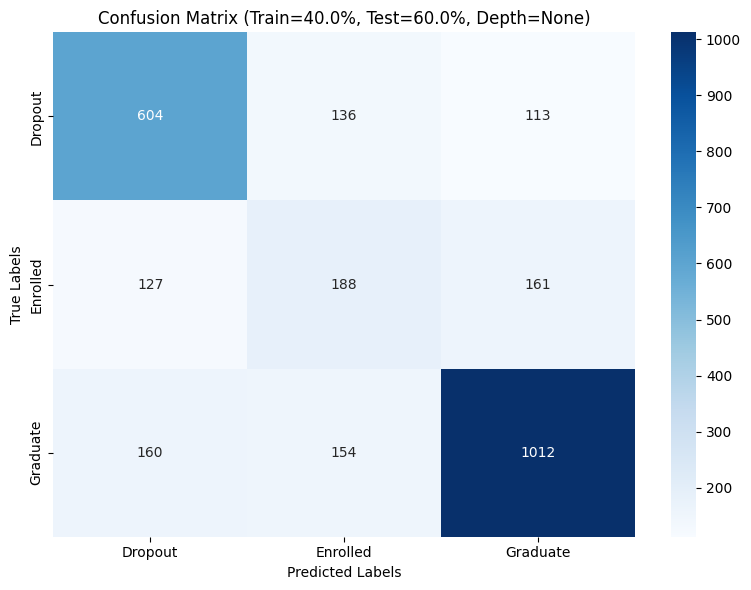


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.686     0.717     0.701       568
    Enrolled      0.339     0.330     0.334       318
    Graduate      0.765     0.750     0.757       884

    accuracy                          0.664      1770
   macro avg      0.597     0.599     0.598      1770
weighted avg      0.663     0.664     0.663      1770



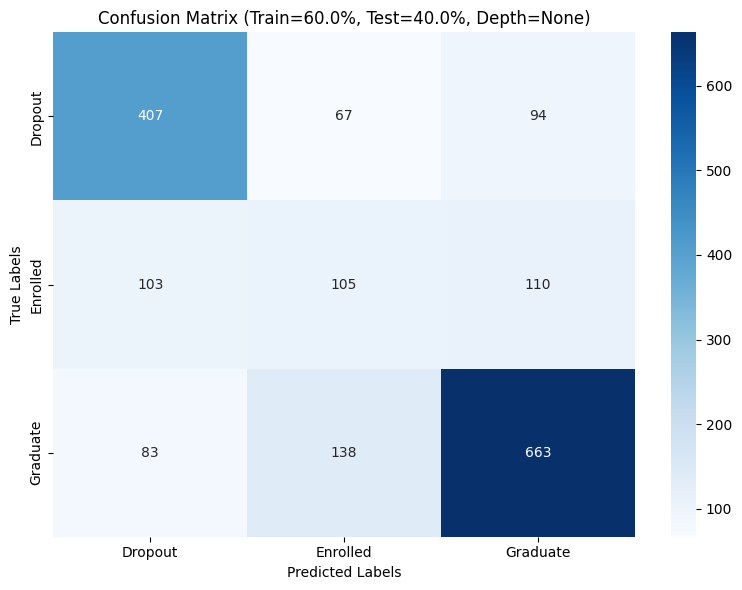

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.65976 to fit


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.679     0.687     0.683       284
    Enrolled      0.367     0.365     0.366       159
    Graduate      0.780     0.776     0.778       442

    accuracy                          0.673       885
   macro avg      0.609     0.609     0.609       885
weighted avg      0.673     0.673     0.673       885



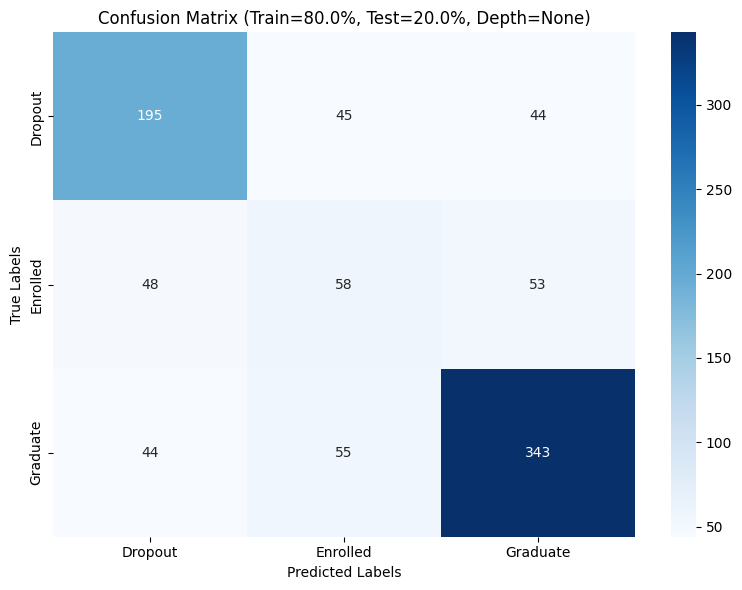

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.640443 to fit


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.716     0.676     0.696       142
    Enrolled      0.305     0.362     0.331        80
    Graduate      0.785     0.760     0.772       221

    accuracy                          0.661       443
   macro avg      0.602     0.600     0.600       443
weighted avg      0.676     0.661     0.668       443



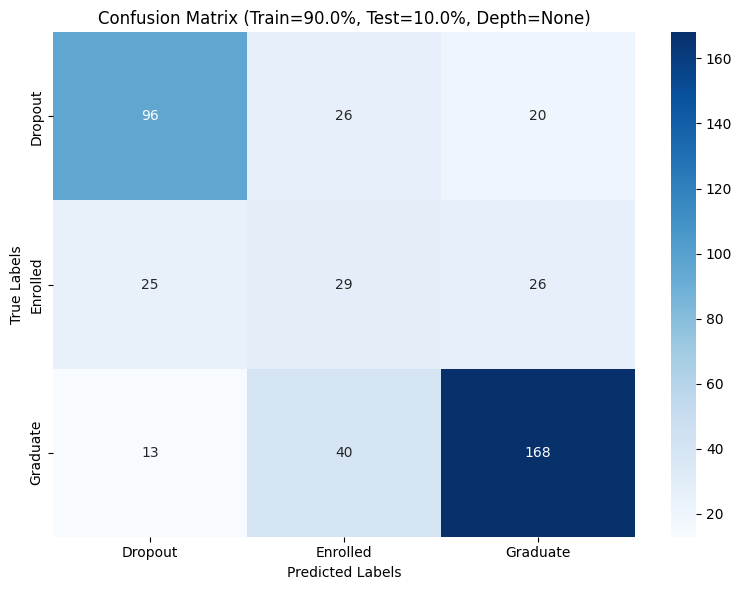

In [12]:
for ratio in ratios:
    feature_test_path = os.path.join("feature_test", ratio, "X_test.csv")
    label_test_path = os.path.join("label_test", ratio, "y_test.csv")
    
    X__train = pd.read_csv(os.path.join("feature_train", ratio, "X_train.csv"))
    y__train = pd.read_csv(os.path.join("label_train", ratio, "y_train.csv"))

    clf = fit_and_visualize_decision_tree(
        X__train,
        y__train,
        ratio=ratio,
        max_depth=None,
        is_show=False
    )

    fit_and_evaluate_decision_tree(
        clf,
        pd.read_csv(feature_test_path),
        pd.read_csv(label_test_path),
        ratio=int(ratio.split('_')[1])*0.01,
        max_depth=None,
    )

## **3.3. Evaluating the decision tree classifiers with different max depths (focus on 80/20 train-test split)**

In [13]:
# Initialize a list to store accuracies for each ratio
accuracies = []

Decision Tree Classifier Report (Max_depth: 2)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.780     0.588     0.671       284
    Enrolled      0.349     0.384     0.365       159
    Graduate      0.760     0.853     0.804       442

    accuracy                          0.684       885
   macro avg      0.630     0.608     0.613       885
weighted avg      0.693     0.684     0.682       885



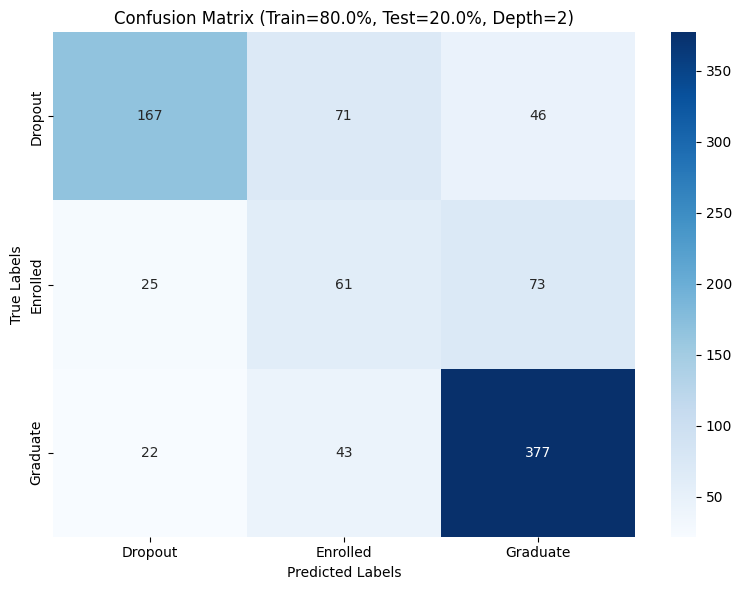


Decision Tree Classifier Report (Max_depth: 3)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.788     0.641     0.707       284
    Enrolled      0.367     0.365     0.366       159
    Graduate      0.760     0.853     0.804       442

    accuracy                          0.697       885
   macro avg      0.638     0.620     0.626       885
weighted avg      0.698     0.697     0.694       885



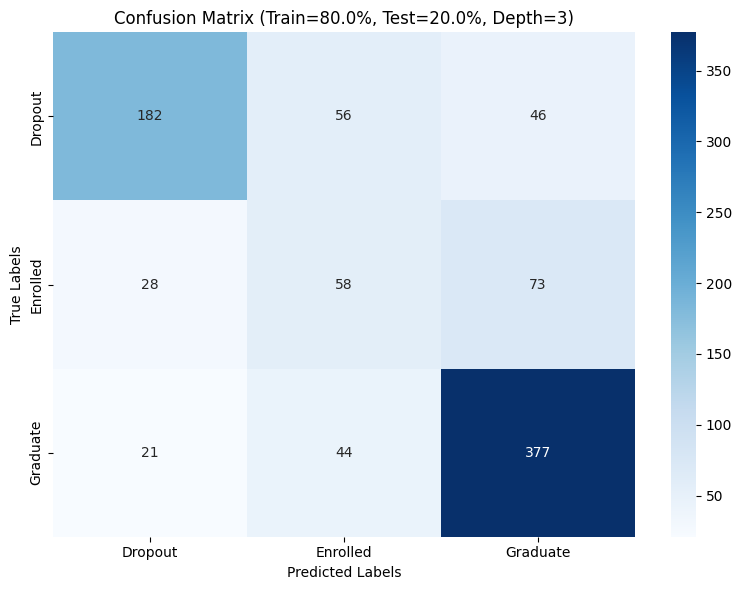


Decision Tree Classifier Report (Max_depth: 4)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.832     0.609     0.703       284
    Enrolled      0.372     0.365     0.368       159
    Graduate      0.745     0.878     0.806       442

    accuracy                          0.699       885
   macro avg      0.649     0.617     0.626       885
weighted avg      0.706     0.699     0.694       885



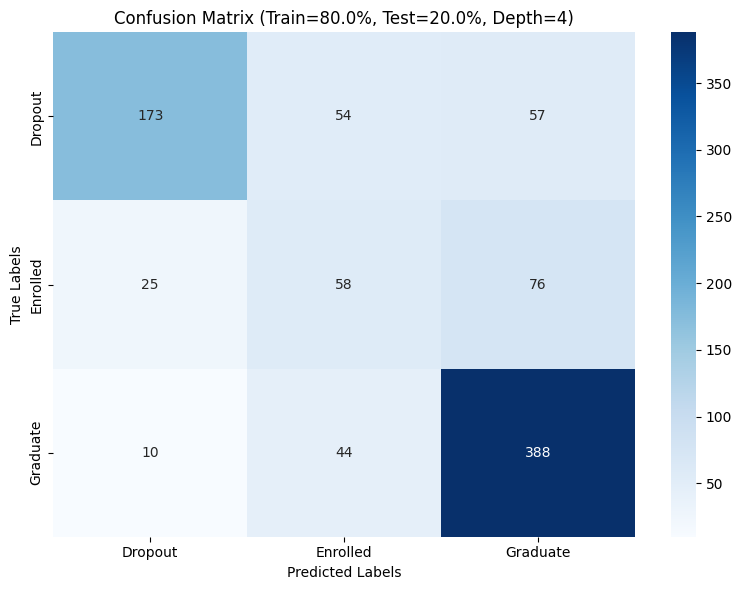


Decision Tree Classifier Report (Max_depth: 5)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.817     0.613     0.700       284
    Enrolled      0.427     0.201     0.274       159
    Graduate      0.710     0.959     0.816       442

    accuracy                          0.712       885
   macro avg      0.651     0.591     0.597       885
weighted avg      0.694     0.712     0.681       885



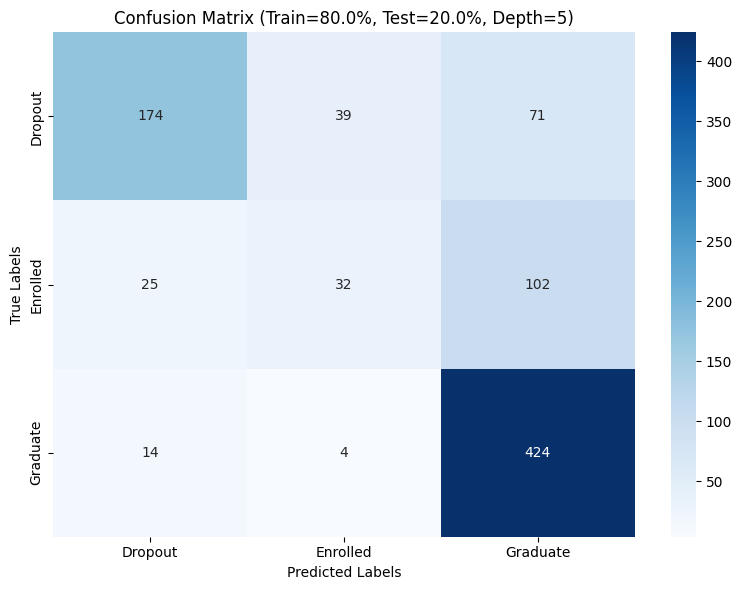


Decision Tree Classifier Report (Max_depth: 6)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.817     0.627     0.709       284
    Enrolled      0.479     0.283     0.356       159
    Graduate      0.735     0.952     0.830       442

    accuracy                          0.728       885
   macro avg      0.677     0.621     0.631       885
weighted avg      0.715     0.728     0.706       885



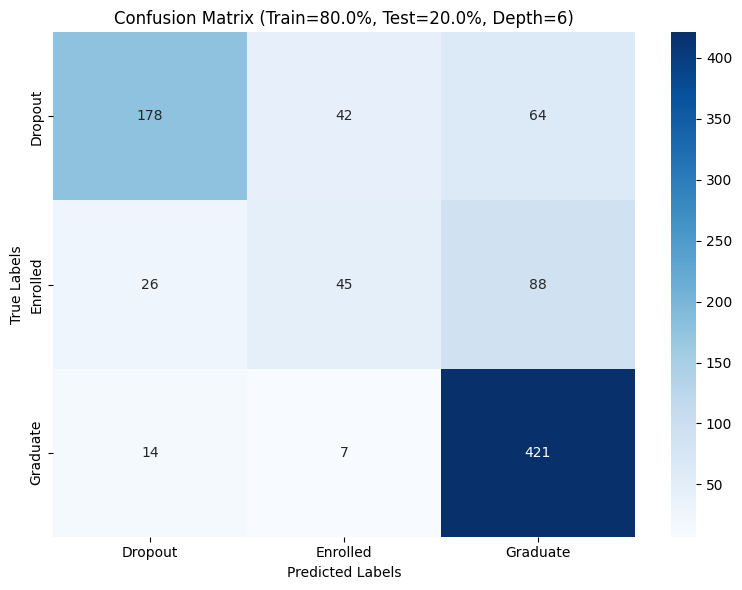


Decision Tree Classifier Report (Max_depth: 7)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.797     0.690     0.740       284
    Enrolled      0.482     0.252     0.331       159
    Graduate      0.754     0.948     0.840       442

    accuracy                          0.740       885
   macro avg      0.677     0.630     0.637       885
weighted avg      0.719     0.740     0.716       885



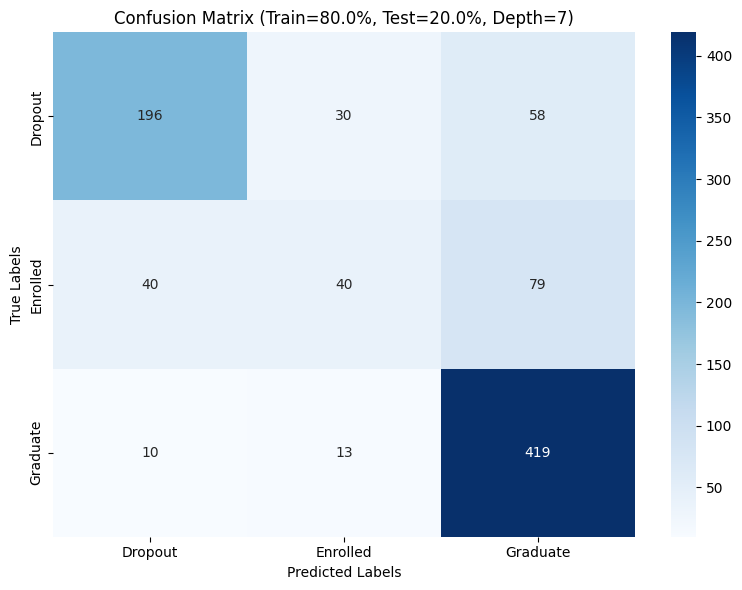

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.65976 to fit


Decision Tree Classifier Report (Max_depth: None)
Classification Report:
               precision    recall  f1-score   support

     Dropout      0.679     0.687     0.683       284
    Enrolled      0.367     0.365     0.366       159
    Graduate      0.780     0.776     0.778       442

    accuracy                          0.673       885
   macro avg      0.609     0.609     0.609       885
weighted avg      0.673     0.673     0.673       885



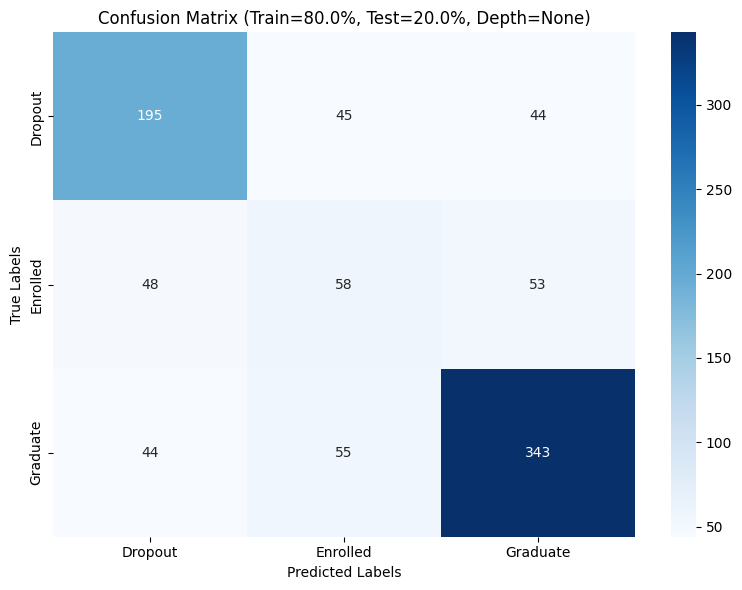

In [14]:
ratio = "80_20"
max_depths = [2, 3, 4, 5, 6, 7, None]

feature_test_path = os.path.join("feature_test", ratio, "X_test.csv")
label_test_path = os.path.join("label_test", ratio, "y_test.csv")

X__train = pd.read_csv(os.path.join("feature_train", ratio, "X_train.csv"))
y__train = pd.read_csv(os.path.join("label_train", ratio, "y_train.csv"))

for max_depth in max_depths:
    clf = fit_and_visualize_decision_tree(
        X__train,
        y__train,
        ratio=ratio,
        max_depth=max_depth,
        is_show=False,
        base_dir="images/80_20_vary_depth"
    )

    accuracy = fit_and_evaluate_decision_tree(
        clf,
        pd.read_csv(feature_test_path),
        pd.read_csv(label_test_path),
        ratio=int(ratio.split('_')[1])*0.01,
        max_depth=max_depth,
    )

    accuracies.append(accuracy)

In [16]:
for max_depth, accuracy in zip(max_depths, accuracies):
    print(f"Max Depth: {max_depth}, Accuracy: {accuracy}")

Max Depth: 2, Accuracy: 0.6836158192090396
Max Depth: 3, Accuracy: 0.6971751412429379
Max Depth: 4, Accuracy: 0.6994350282485876
Max Depth: 5, Accuracy: 0.711864406779661
Max Depth: 6, Accuracy: 0.727683615819209
Max Depth: 7, Accuracy: 0.7401129943502824
Max Depth: None, Accuracy: 0.6734463276836158


Thus,

|max_depth|None|2|3|4|5|6|7|
|---------|----|-|-|-|-|-|-|
|**accuracy**|0.6734|0.6836|0.6972|0.6994|0.7119|0.7277|0.7401|

**Visualize the accuracy of the decision tree classifier with different max depth values.**

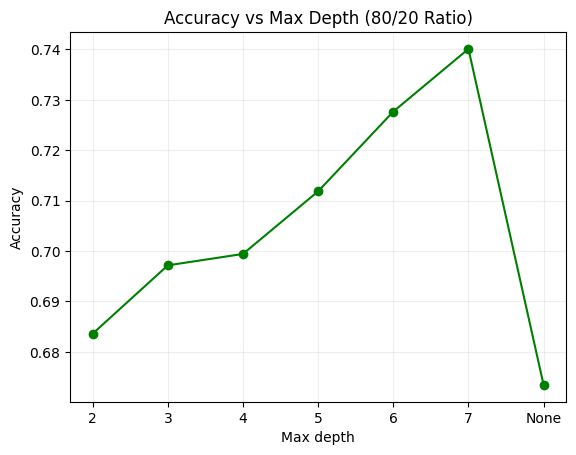

In [18]:
plt.plot([str(x) for x in max_depths],
         accuracies, color='green', marker='o')
plt.title('Accuracy vs Max Depth (80/20 Ratio)')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.grid(alpha=0.2)
plt.show()

We choose max_depth = 7 with the highest acuracy = 0.74 if we need identify Dropout/Graduate well 